# 230518_causal_tracing_activations_v4


# Import libraries

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer, set_seed
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

/rds/general/user/jj1122/home/anaconda3/envs/m2d2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
torch.manual_seed(718)
set_seed(718)

In [3]:
# ROME
# - localisation: pre-trained LM을 대상으로 지식 정보가 담겨있는 모듈을 찾아냄
# - ROME: 해당 부분에 적합한 

# 내가 만들고 싶은 model editing은 fine-tuning을 대체할 수 있는 방법이었음

In [21]:
dataset_nm = "Religion_and_belief_systems"
# dataset_path = f"../m2d2/dataset/{dataset_nm}/train.txt"
cache_dir="/rds/general/user/jj1122/ephemeral/.cache/huggingface"

In [18]:
device_id = 'cuda'
tuned_model_path = "/rds/general/user/jj1122/home/projects/m2d2/dataset/Religion_and_belief_systems/models"
n_layers = 12
list_modules = ['attn', 'mlp']
trace_module_id = "transformer.h.{l}.{m}"

In [19]:
list_trace_module_ids = []

for l in range(n_layers):
    for m in list_modules:
        list_trace_module_ids.append(trace_module_id.format(l=l, m=m))

print(list_trace_module_ids[:3])

['transformer.h.0.attn', 'transformer.h.0.mlp', 'transformer.h.1.attn']


# Model

## load models

In [23]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to(device_id)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(tuned_model_path)
tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

In [ ]:
# base_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device_id)
# tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

In [ ]:
# diff_weights = {}
# for tuned_tup, base_tup in zip(list(tuned_model.named_parameters()), list(base_model.named_parameters())):
#     diff_weights[tuned_tup[0]] = torch.abs(tuned_tup[1] - base_tup[1]).mean().item()
    
# diff_weights

# Data

In [22]:
dataset = load_dataset("machelreid/m2d2", dataset_nm, cache_dir=cache_dir)

Found cached dataset m2d2 (/rds/general/user/jj1122/ephemeral/.cache/huggingface/machelreid___m2d2/Religion_and_belief_systems/0.0.0/eb235f33a5de3163c10549b7f63c906910539c8a8c0ec5ade1285ccbf5067d00)
100%|██████████| 3/3 [00:00<00:00, 229.65it/s]


In [ ]:
# np.random.seed(718)

# x = 10 * np.random.randint(100000)

# dataset['train']['text'][x:x+10]

In [ ]:
# # input_text = "He was a religious scholar and a prolific writer. Many of his works are used as references for church members"

# # input_text = "In popular and media culture, Anubis is often falsely portrayed as the sinister god of the dead"

# # input_text = "Ankou appears as a man or skeleton wearing a black robe and a large hat which conceals his face, or, on occasion, simply as a shadow"

# # input_text = "Zechariah's vision of recently deceased Joshua the High Priest depicts a dispute in the heavenly throne room between Satan and the Angel of the Lord"

# input_text = "The Transcendental Argument for the Existence of God (TAG) is the argument that attempts to prove the existence of God by arguing that logic, morals, and science ultimately presuppose a supreme being and that God must therefore be the source of logic and morals"


In [24]:
list_test_data = [x for x in dataset['test']['text'].copy() if x!=''] 

In [25]:
def load_model():
    return GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

In [26]:
def save_clean_activation(m_id):
    def save_clean_activation_hook(module, _input, _output):
#         print(m_id, _output.shape)
        if m_id.endswith('attn'):
            clean_activations[m_id] = _output[0].detach()
        elif m_id.endswith('mlp'):
#         else:
            clean_activations[m_id] = _output.detach()
    return save_clean_activation_hook


def corrupt_input_vector(module, _input):#, _output):
    torch.manual_seed(718)
    std = torch.std(_input[0])
    return tuple([_input[0] + (std*1.5) * torch.randn(_input[0].shape).to(device_id), ])

def restore_activation(m_id):
    def restore_activation_hook(module, _input, _output):
        clean_activation = clean_activations[m_id]#[:, t]
        if m_id.endswith('attn'):
#             corrupted_activation = _output[0].detach()
#             base_output[:, t] = tuned_output
#             corrupted_activation = clean_activation
            return tuple([clean_activation, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):           
            base_output = _output.detach()
#             base_output[:, t] = tuned_output
            base_output = clean_activation
            return base_output
    return restore_activation_hook

In [ ]:
def restore_activation(m_id):
    def restore_activation_hook(module, _input, _output):
        clean_activation = clean_activations[m_id]
        if m_id.endswith('attn'):
            return tuple([clean_activation, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):           
            base_output = _output.detach()
            base_output = clean_activation
            return base_output
    return restore_activation_hook

In [27]:
def corrupt_input_vector(module, _input):#, _output):
    torch.manual_seed(718)
    std = torch.std(_input[0])
    return tuple([_input[0] + (std*1.5) * torch.randn(_input[0].shape).to(device_id), ])

In [28]:
def restore_activation(m_id):
    def restore_activation_hook(module, _input, _output):
        clean_activation = clean_activations[m_id]#[:, t]
        if m_id.endswith('attn'):
#             corrupted_activation = _output[0].detach()
#             base_output[:, t] = tuned_output
#             corrupted_activation = clean_activation
            return tuple([clean_activation, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):           
            base_output = _output.detach()
#             base_output[:, t] = tuned_output
            base_output = clean_activation
            return base_output
    return restore_activation_hook

## 10:45

In [30]:
list_results = [{} for x in range(len(list_test_data)) if x != ""]

for input_idx, input_text in enumerate(list_test_data):
    
    if input_idx % 1000 == 0:
        print(f"input_idx: {input_idx}")
    
    inputs = gpt2_tokenizer(input_text, return_tensors="pt").to(device_id)
    n_tokens = inputs['input_ids'].shape[1]
    
    list_input_text = gpt2_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

    for idx in range(1, n_tokens):
        if not list_input_text[idx].startswith("Ġ"):
            list_input_text[idx-1] = list_input_text[idx-1] + "##"
        list_input_text[idx] = list_input_text[idx].replace("Ġ", "")
        
    # First run: clean run
    clean_activations = {}
    tuned_model = load_model()
    for m_id in list_trace_module_ids:
        tuned_model.get_submodule(m_id).register_forward_hook(save_clean_activation(m_id))
        
    with torch.no_grad():
        tuned_model.eval()
        clean_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)    
        clean_loss = np.exp(clean_outputs.loss.item())
    
    # Second run: corrupted run    
    tuned_model = load_model()
    tuned_model.get_submodule("transformer.h.0.attn").register_forward_pre_hook(corrupt_input_vector)    
    with torch.no_grad():
        torch.manual_seed(718)
        set_seed(718)
        tuned_model.eval()
        corrupted_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
        corrupted_loss = np.exp(corrupted_outputs.loss.item())
        
    corrupted_loss    

    # Third run: corrupted-with-restoration run    
    restored_loss = {}
    tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

    with torch.no_grad():
        tuned_model.eval()
        tuned_model.get_submodule("transformer.h.0.attn").register_forward_pre_hook(corrupt_input_vector)
        for m_id in list_trace_module_ids:
            hook = tuned_model.get_submodule(m_id).register_forward_hook(restore_activation(m_id))
            restored_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
            restored_loss[m_id] = np.exp(restored_outputs.loss.item())
            hook.remove()
            
    list_results[input_idx]['clean_loss'] = clean_loss
    list_results[input_idx]['corrupted_loss'] = corrupted_loss
    list_results[input_idx]['restored_loss'] = restored_loss

input_idx: 0
input_idx: 1000
input_idx: 2000
input_idx: 3000


KeyboardInterrupt: 

In [32]:
import pickle as pkl
with open('230607_run_outputs.pkl', 'wb') as pkl_file:
    pkl.dump(list_results, pkl_file)

In [34]:
for i, d in enumerate(list_results):
    if len(d) == 0:
        print(i)
        break

3040


In [36]:
list_results_temp = list_results[:3000]

# Main

## first run - clean

### register hook - save_clean_activation

### get clean_activations & clean_loss

13.573352837326823

## second run - corruped

### register hook - corrupt_input_vector

### get corrupt_input_vector & corrupted_loss

18.395775714257592

## Thrid run - corrupted-with-restoration run

### register hook - restore_activation & restored losses

In [643]:
list(restored_loss.items())[:10]

[('transformer.h.0.attn', 13.573352837326823),
 ('transformer.h.0.mlp', 14.274880534457854),
 ('transformer.h.1.attn', 21.543103091989984),
 ('transformer.h.1.mlp', 20.8595076933879),
 ('transformer.h.2.attn', 17.51346675330437),
 ('transformer.h.2.mlp', 18.091306491554267),
 ('transformer.h.3.attn', 16.443810897114936),
 ('transformer.h.3.mlp', 16.982345444060076),
 ('transformer.h.4.attn', 17.352509155673943),
 ('transformer.h.4.mlp', 18.33990111156065)]

## Losses

In [37]:
list_results_temp[0]

{'clean_loss': 63.91878399603464,
 'corrupted_loss': 132.82606231021126,
 'restored_loss': {'transformer.h.0.attn': 63.91878399603464,
  'transformer.h.0.mlp': 72.45914462107228,
  'transformer.h.1.attn': 108.48300584563944,
  'transformer.h.1.mlp': 98.26031753662475,
  'transformer.h.2.attn': 105.73504141607684,
  'transformer.h.2.mlp': 157.61139900333075,
  'transformer.h.3.attn': 114.14795095597133,
  'transformer.h.3.mlp': 115.4669494255801,
  'transformer.h.4.attn': 100.84907069077829,
  'transformer.h.4.mlp': 95.89280867821321,
  'transformer.h.5.attn': 131.30313272151864,
  'transformer.h.5.mlp': 97.53559238094321,
  'transformer.h.6.attn': 102.20920983898758,
  'transformer.h.6.mlp': 109.59817642652683,
  'transformer.h.7.attn': 106.16284752779694,
  'transformer.h.7.mlp': 95.22004636798862,
  'transformer.h.8.attn': 112.71103032371055,
  'transformer.h.8.mlp': 108.70722262992827,
  'transformer.h.9.attn': 127.16515070581757,
  'transformer.h.9.mlp': 84.2516244105539,
  'transf

In [49]:
def parse_code(row):
    list_code = row.code.split(".")
    row['l'] = int(list_code[2])
    row['m'] = list_code[3]
#     row['t'] = int(list_code[4])
    return row

In [53]:
list_df_ide_temp = []
for i, d in enumerate(list_results_temp):
    df_t = pd.DataFrame.from_dict(d['restored_loss'], orient='index')
    TE = (corrupted_loss - clean_loss) / clean_loss
    IDE = {}
    for m_id in list_trace_module_ids:
        IDE[m_id] = (restored_loss[m_id] - clean_loss) / clean_loss
    
    df_ide = pd.DataFrame.from_dict(IDE, orient='index').reset_index()
    df_ide.columns = ['code', 'ide']
    df_ide = df_ide.apply(lambda row: parse_code(row), axis=1)
    df_ide["seq"] = i
    list_df_ide_temp.append(df_ide)
    break

In [55]:
df_ide

,code,ide,l,m,seq
0,transformer.h.0.attn,-0.246547,0,attn,0
1,transformer.h.0.mlp,-0.165156,0,mlp,0
2,transformer.h.1.attn,1.243991,1,attn,0
3,transformer.h.1.mlp,0.427174,1,mlp,0
4,transformer.h.2.attn,-0.017259,2,attn,0
5,transformer.h.2.mlp,0.020662,2,mlp,0
6,transformer.h.3.attn,-0.049197,3,attn,0
7,transformer.h.3.mlp,-0.042981,3,mlp,0
8,transformer.h.4.attn,-0.026493,4,attn,0
9,transformer.h.4.mlp,0.050634,4,mlp,0


In [644]:
clean_loss, corrupted_loss, np.mean(list(restored_loss.values()))

(13.573352837326823, 18.395775714257592, 17.73122174651327)

In [645]:
# TE = (base_loss - tuned_loss) / base_loss
# IDE = {}
# for m_id in list_trace_module_ids:
#     for t in range(n_tokens):
#         IDE[m_id + f'.{t}'] = restored_loss[m_id + f'.{t}'] / base_loss
        
TE = (corrupted_loss - clean_loss) / clean_loss
IDE = {}
for m_id in list_trace_module_ids:
    IDE[m_id] = (restored_loss[m_id] - clean_loss) / clean_loss

In [646]:


df_ide = pd.DataFrame.from_dict(IDE, orient='index').reset_index()
df_ide.columns = ['code', 'ide']
df_ide = df_ide.apply(lambda row: parse_code(row), axis=1)
# df_ide['token'] = df_ide['t'].apply(lambda x: list_input_text[int(x)])

## Results

##### He was a religious scholar and a prolific writer. Many of his works are used as references for church members

<Axes: xlabel='None-l', ylabel='m'>

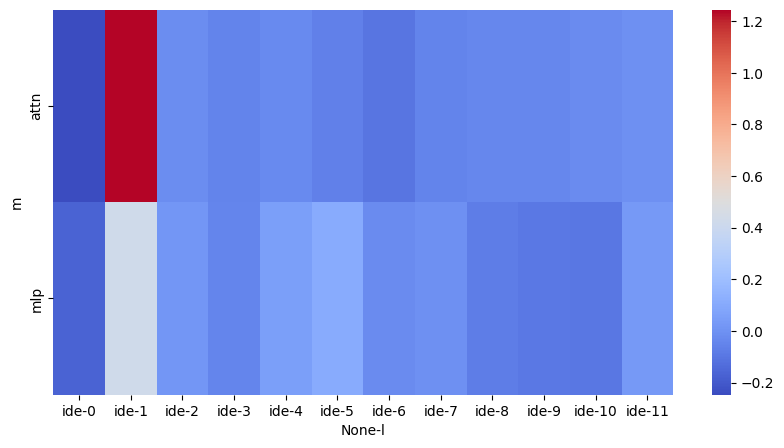

In [58]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code', 'seq'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=0.3, vmin=0, vmax=1.2, vmin=0.8
)

##### 'In popular and media culture, Anubis is often falsely portrayed as the sinister god of the dead'


<Axes: xlabel='None-l', ylabel='m'>

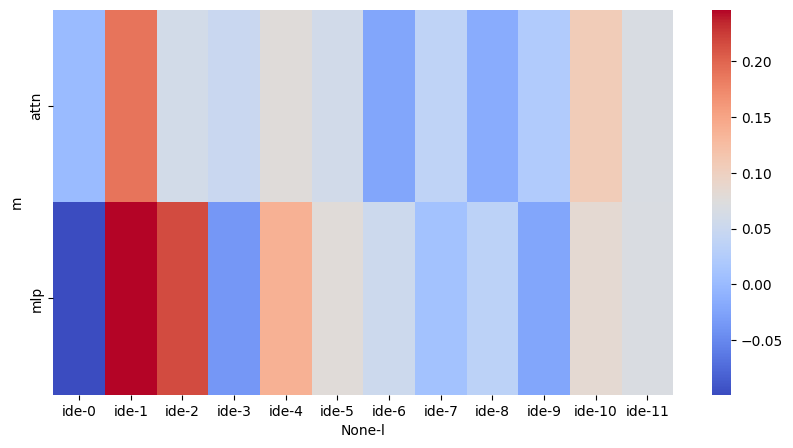

In [599]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### Elderly people often have limited regenerative abilities and are more susceptible to disease, syndromes, injuries and sickness than younger adults.

<Axes: xlabel='None-l', ylabel='m'>

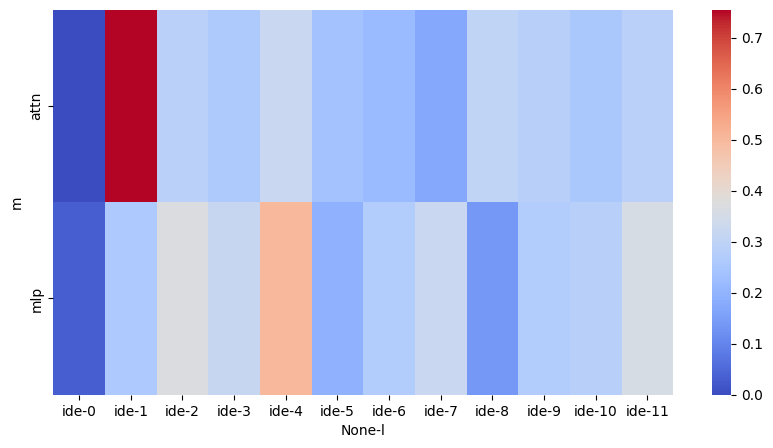

In [615]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### "Zechariah's vision of recently deceased Joshua the High Priest depicts a dispute in the heavenly throne room between Satan and the Angel of the Lord"


<Axes: xlabel='None-l', ylabel='m'>

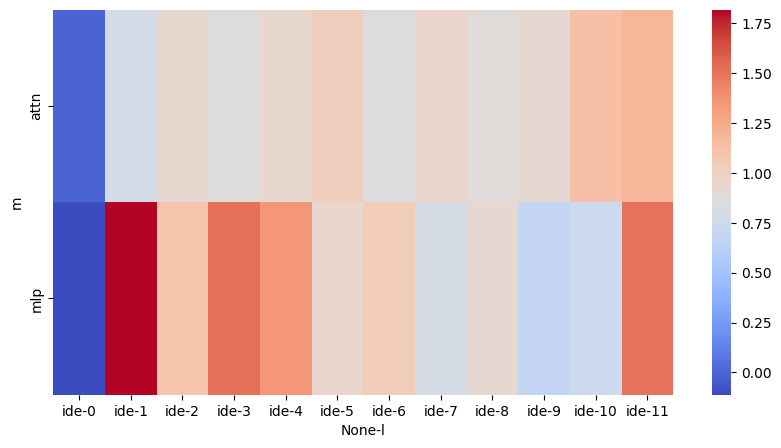

In [631]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### The Transcendental Argument for the Existence of God (TAG) is the argument that attempts to prove the existence of God by arguing that logic, morals, and science ultimately presuppose a supreme being and that God must therefore be the source of logic and morals

<Axes: xlabel='None-l', ylabel='m'>

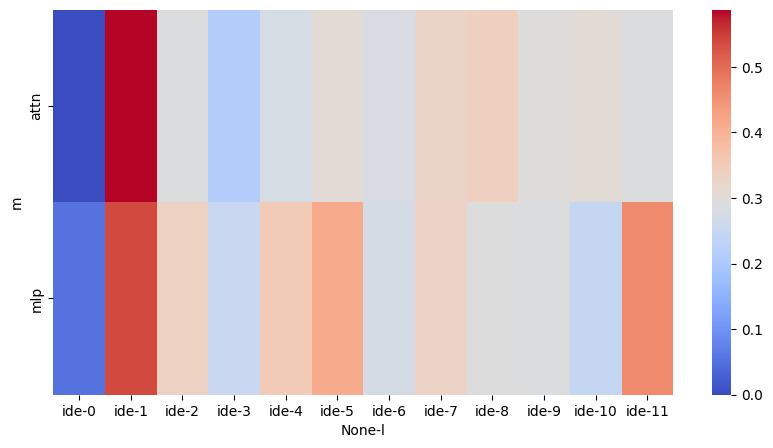

In [647]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

## Conclusion
Couldn't find a specific pattern.  
I will extend this approach, using the entire dataset and aggregating IDE values.